<a href="https://colab.research.google.com/github/leticialsilva-exe/MachineLearning_studies/blob/main/transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Import RMSprop from tensorflow.keras.optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator


from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model


In [5]:
#downloading the database cats&dogs

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2025-01-16 20:42:03--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 96.7.158.17, 2600:1409:8800:387::317f, 2600:1409:8800:393::317f
Connecting to download.microsoft.com (download.microsoft.com)|96.7.158.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   112MB/s    in 10s     

2025-01-16 20:42:13 (76.1 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [6]:
## viewing the number of images in each class/file
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [7]:
try:
  os.mkdir('/tmp/cats-v-dogs')
  os.mkdir('/tmp/cats-v-dogs/training')
  os.mkdir('/tmp/cats-v-dogs/testing')
  os.mkdir('/tmp/cats-v-dogs/training/cats')
  os.mkdir('/tmp/cats-v-dogs/training/dogs')
  os.mkdir('/tmp/cats-v-dogs/testing/cats')
  os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
  pass

In [12]:
!pip install shutil --quiet # Install shutil if needed, though unlikely

from posixpath import split
import shutil # Import the shutil module for file operations

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")

  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    shutil.copyfile(this_file, destination)

  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    shutil.copyfile(this_file, destination)

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
CAT_TRAINING_DIR = "/tmp/cats-v-dogs/training/cats/"
CAT_TESTING_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
DOG_TRAINING_DIR = "/tmp/cats-v-dogs/training/dogs/"
DOG_TESTING_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, CAT_TRAINING_DIR, CAT_TESTING_DIR, split_size)
split_data(DOG_SOURCE_DIR, DOG_TRAINING_DIR, DOG_TESTING_DIR, split_size)


ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil
666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [13]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))


11250
11250
1250
1250


In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc']) # Use RMSprop after importing it


In [27]:
TRAINING_DIR ="/tmp/cats-v-dogs/training"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))



Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [28]:
#etapa de treinamento da rede
history = model.fit(train_generator,
                              epochs=15,
                              steps_per_epoch=90,
                              validation_data=validation_generator,
                              validation_steps=6)

#

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 5/90 ━━━━━━━━━━━━━━━━━━━━ 11:13 8s/step - acc: 0.5370 - loss: 1.3699

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 568s 6s/step - acc: 0.5233 - loss: 0.8113 - val_acc: 0.5400 - val_loss: 0.7021
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 544s 6s/step - acc: 0.5824 - loss: 0.6807 - val_acc: 0.6450 - val_loss: 0.6511
Epoch 3/15
45/90 ━━━━━━━━━━━━━━━━━━━━ 4:21 6s/step - acc: 0.6410 - loss: 0.6410

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


90/90 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - acc: 0.6366 - loss: 0.6399 - val_acc: 0.7133 - val_loss: 0.5798
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 542s 6s/step - acc: 0.6695 - loss: 0.6056 - val_acc: 0.7217 - val_loss: 0.5715
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 518s 6s/step - acc: 0.7313 - loss: 0.5383 - val_acc: 0.6600 - val_loss: 0.6251
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - acc: 0.7409 - loss: 0.5202 - val_acc: 0.7733 - val_loss: 0.4910
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 560s 6s/step - acc: 0.7467 - loss: 0.5051 - val_acc: 0.7933 - val_loss: 0.4447
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 544s 6s/step - acc: 0.7888 - loss: 0.4553 - val_acc: 0.8067 - val_loss: 0.4270
Epoch 9/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - acc: 0.7928 - loss: 0.4357 - val_acc: 0.7500 - val_loss: 0.5199
Epoch 10/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 529s 6s/step - acc: 0.7978 - loss: 0.4260 - val_acc: 0.8600 - val_loss: 0.4116
Epoch 11/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 535s 6s/step - acc: 0.8106 - loss: 

<Figure size 640x480 with 0 Axes>

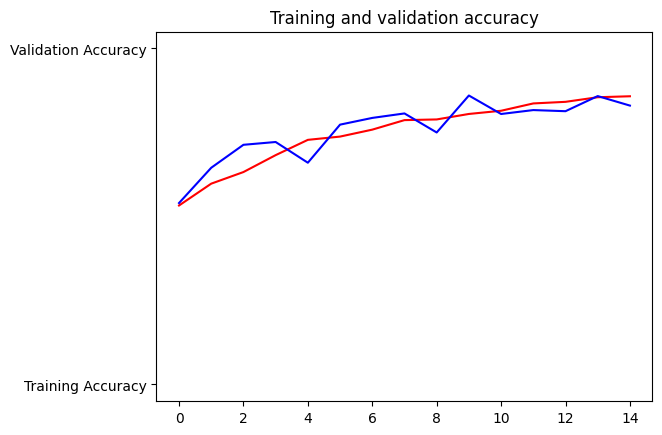

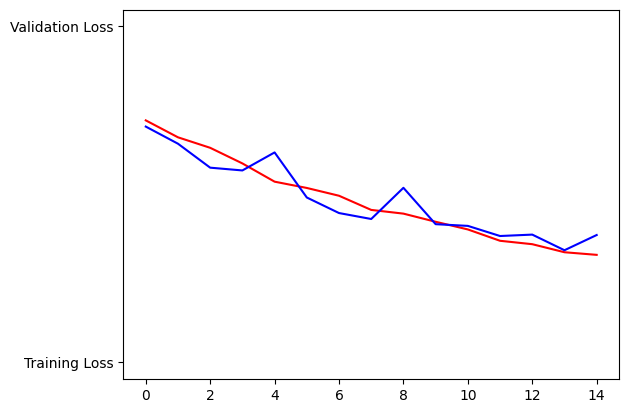

<Figure size 640x480 with 0 Axes>

In [29]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

# plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

#desired output are charts with training and validation metrics, no crash